# Threshold-Based Segmentation

Our first step in breast segmentation is to separate the foreground of the mammogram containing the breast ROI from the background. From a grayscale mammogram, we can use threshold-based segmentation to create a binary image or mask, that, when applied to the original image, separates the foreground and the ROI from the background.

In the binary mask, each pixel has one of two values: ‘0’ representing the background, and ‘1’, corresponding to the image foreground.  Whether the pixel value in the binary mask is assigned a 0 or 1 depends on whether the associated *image* pixel value meets a designated or automatically selected threshold. Generally speaking, image pixel values less than or equal to the threshold are 0 in the corresponding binary mask, and all other pixel values are set to 1.

Two commonly used threshold-based segmentation techniques are global threshold segmentation and adaptive local threshold segmentation.

## Global Threshold Segmentation

Global threshold segmentation applies a single designated or automatically selected threshold value to the entire image.  Specifically, let $I$ be the input image with height $H$ and width $W$ pixels, and that $I_{x,y}$ represents the gray value of row $x$ and column $y$ of $I$, such that $0 \le x < H, 0 \le y < W$. Then, $B_{x,y}$ represents the binary value in row $x$ and column $y$ of binary mask $B$, and is given by:

```{math}
:label: global_threshold
B_{x,y} = \begin{cases}
1 & if I_{x,y} > T \\
0 & if I_{x,y} \le T \\
\end{cases}
```

where $T$ is a global threshold.

To illustrate, let’s create some binary masks for our test images using a manually set threshold $T=10$.

/home/john/projects/bcd/bcd/preprocess/image/analysis/threshold.py:114: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  ["a", "b", "c", "d"]["e", "f", "g", "h"], ["i", "j", "k", "l"]


/home/john/projects/bcd/bcd/preprocess/image/analysis/threshold.py:114: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  ["a", "b", "c", "d"]["e", "f", "g", "h"], ["i", "j", "k", "l"]
/home/john/projects/bcd/bcd/preprocess/image/analysis/threshold.py:114: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  ["a", "b", "c", "d"]["e", "f", "g", "h"], ["i", "j", "k", "l"]
/home/john/projects/bcd/bcd/preprocess/image/analysis/threshold.py:114: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  ["a", "b", "c", "d"]["e", "f", "g", "h"], ["i", "j", "k", "l"]
/home/john/projects/bcd/bcd/preprocess/image/analysis/threshold.py:114: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  ["a", "b", "c", "d"]["e", "f", "g", "h"], ["i", "j", "k", "l"]


TypeError: list indices must be integers or slices, not tuple

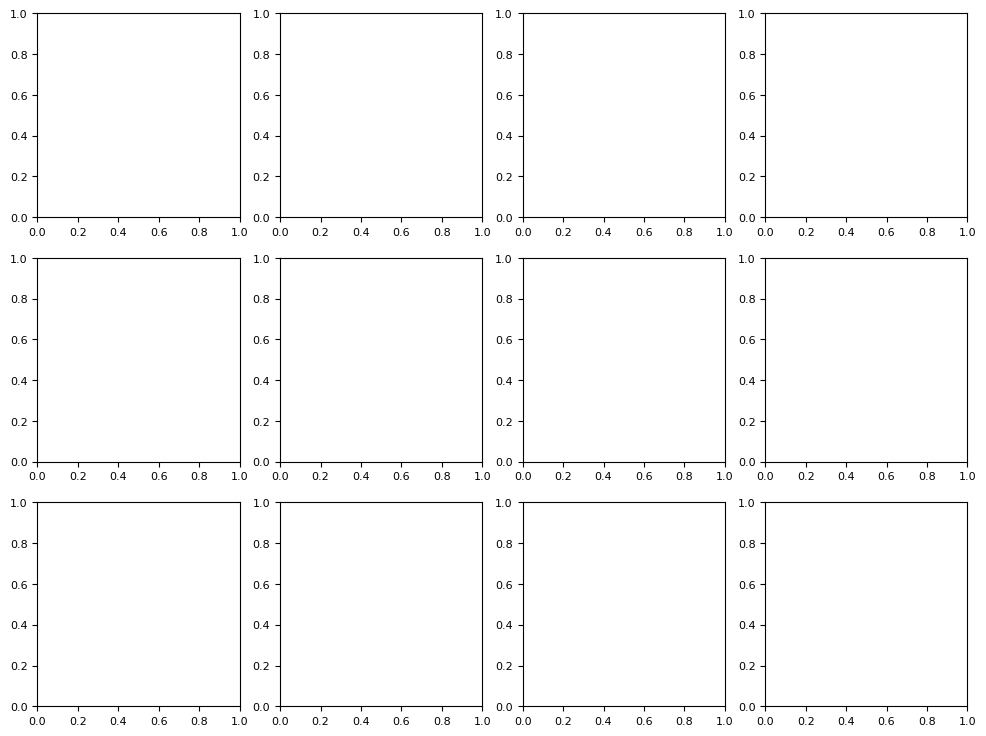

In [1]:
import os
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from myst_nb import glue

from bcd.preprocess.image.analysis.threshold import (
    ThresholdLi, ThresholdISOData, ThresholdTriangle, ThresholdOTSU, ThresholdAdaptiveMean, ThresholdAdaptiveGaussian, TryAllThresholds, ThresholdManual
)

img1 = "data/image/1_dev/converted/train/benign/347c2455-cb62-40f8-a173-9e4eb9a21902.png"
img2 = "data/image/1_dev/converted/train/benign/4ed91643-1e06-4b2c-8efb-bc60dd9e0313.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/malignant/596ef5db-9610-4f13-9c1a-4c411b1d957c.png"

img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

images = (img1,img2,img3,img4)

analysis = ThresholdManual(threshold=10)
fig = analysis.analyze(images=images)

glue("threshold_manual_10", fig)

```{glue:figure} threshold_manual_10
---
align: center
name: threshold_manual_10_fig
---
Manual Threshold-Based Segmentation with $T=10$
```

In {numref}`threshold_manual_10_fig`, we have our four randomly selected images, the associated binary masks, and the output images. At threshold $T=10$, we have a clear separation between foreground and background; however, we have little to no artifact suppression.

Let’s examine the effect of increasing the threshold to $T=100$.

In [ ]:
analysis = ThresholdManual(threshold=100)
fig = analysis.analyze(images=images)

glue("threshold_manual_100", fig)

```{glue:figure} threshold_manual_100
---
align: center
name: threshold_manual_100_fig
---
Manual Threshold-Based Segmentation with $T=100$
```

{numref}`threshold_manual_10_fig` and {numref}`threshold_manual_100_fig` illustrate the first key takeaway of this section.

`````{admonition} In threshold segmentation, the choice of threshold is crucial!
:class: tip
Different thresholds may yield dramatically different segmentation results.
`````

A threshold that is too low tends to produce over-segmentation, failing to separate artifacts from regions of interest, and combining distinct objects into single structures.  A high threshold can make objects smaller, as structures of interest are designated to the background. So, what are the principled ways by which an appropriate threshold is selected?

This leads to our second key takeaway.

`````{admonition} Choosing a threshold manually should be avoided, when possible!
:class: tip
Manual thresholding is inefficient, irreproducible, and a huge source of user bias
`````

...rant inbound in 3,…2,…

Selecting thresholds manually is tedious, time-consuming, and a huge source of user bias. It is based upon human perception of what information should be extracted from the image, leading to high intra- and inter-user variability; further compounded by the inherent variability in digital mammography. One fixed threshold will not extract similar features from different images. Manual thresholding has little to no reproducibility and it is incompatible with automatic, image-driven thresholding that is based on image-intrinsic properties and not on subjective real-time user decisions.

## Automatic Thresholding

Image processing literature is replete with automatic thresholding algorithms that are based on a wide range of image properties. The benefits of automatic thresholding are:

- No user bias is introduced during thresholding,
- Thresholds are objectively determined and image-specific,
- They are reproducible, in that an image will always have the same binarization result,
- They are fast and computationally efficient, lending themselves to image preprocessing automation.